# Deep Learning in Virtual Screening Review

See skeleton outline here:
https://docs.google.com/document/d/1KuKU_EHq9j5bYitJWemYmKid9lSvPWwx5vwE6a8vqJU/edit?usp=sharing

## Figure generation
This notebook serves to generate the figures for the review.

Possible drugs:
- Vatalanib: c1ccc2c(c1)c(nnc2Nc3ccc(cc3)Cl)Cc4ccncc4
- Semaxanib: Cc1cc([nH]c1/C=C\2/c3ccccc3NC2=O)C 
- Fasudil: c1cc2cnccc2c(c1)S(=O)(=O)N3CCCNCC3, C1CNCCN(C1)S(=O)(=O)C2=CC=CC3=C2C=CN=C3

Link from here: https://www.icoa.fr/pkidb/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

### Canonical SMILES
We first need the canonical version of the SMILES.

In [2]:
def to_canonical(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    return {'can_smiles': Chem.MolToSmiles(molecule,canonical=True), 'molecule': molecule}

In [3]:
smiles = "c1cc2cnccc2c(c1)S(=O)(=O)N3CCCNCC3"

In [4]:
mol = to_canonical(smiles)

In [5]:
canonical_smiles = mol['can_smiles']
print("Canonical smiles: ", canonical_smiles)
print("Length of canonical smiles: ", len(canonical_smiles))

Canonical smiles:  O=S(=O)(c1cccc2cnccc12)N1CCCNCC1
Length of canonical smiles:  32


### Molecular graph
Obtain the molecular graph in RDKit

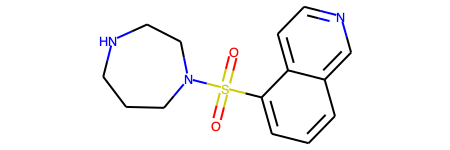

In [6]:
molecule = mol['molecule']
molecule

In [7]:
img = Draw.MolToImage(molecule)
img.save("fasudil.png")

### Fingerprint
Draw a Morgan fingerprint

In [8]:
def mol2morgan(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(molecule, 5, 50))

In [9]:
morgan_fp = mol2morgan(canonical_smiles)
print(morgan_fp)

[1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
f, ax = plt.subplots()
ax.imshow(np.reshape(morgan_fp, (1, 50)),  cmap = colors.ListedColormap([(1, 1, 1), 'black']))
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()
f.savefig('morgan_fp.png',
          dpi=900, facecolor='w', edgecolor='b',
          orientation='portrait', format=None,
          transparent=True, bbox_inches=None, pad_inches=0)

### Graph featurizer
#### Adjacency matrix

In [11]:
adj_mat = Chem.rdmolops.GetAdjacencyMatrix(molecule)

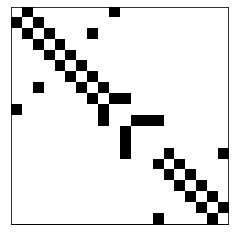

In [12]:
f, ax = plt.subplots()
ax.imshow(adj_mat, cmap = colors.ListedColormap([(1, 1, 1), 'black']))
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 
plt.show()
f.savefig('adj_matrix.png')

#### Feature matrix

In [13]:
nb_features = 3
X = np.zeros((molecule.GetNumAtoms(), nb_features))

for i, atom in enumerate(molecule.GetAtoms()):
    X[i,:] = [atom.GetAtomicNum(), atom.GetDegree(), atom.GetIsAromatic()]
    
print(f'Feature matrix X with shape {X.shape} \n {X}')

Feature matrix X with shape (20, 3) 
 [[ 6.  2.  1.]
 [ 6.  2.  1.]
 [ 6.  3.  1.]
 [ 6.  2.  1.]
 [ 7.  2.  1.]
 [ 6.  2.  1.]
 [ 6.  2.  1.]
 [ 6.  3.  1.]
 [ 6.  3.  1.]
 [ 6.  2.  1.]
 [16.  4.  0.]
 [ 8.  1.  0.]
 [ 8.  1.  0.]
 [ 7.  3.  0.]
 [ 6.  2.  0.]
 [ 6.  2.  0.]
 [ 6.  2.  0.]
 [ 7.  2.  0.]
 [ 6.  2.  0.]
 [ 6.  2.  0.]]


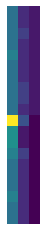

In [14]:
f = plt.figure()
plt.imshow(X)
plt.axis('off')
plt.show()
f.savefig('feature_matrix.png')

### Label & One hot encoding of SMILES

In [15]:
def get_unique_elements_as_dict(list_):
    '''
    Given a list, obtain dictonary with unique elements as keys and integer as values.
    '''
    all_elements = ''.join(list_)
    unique_elements = sorted(list(set(all_elements)))
    #unique_elements.sort()
    return {unique_elem: i for i, unique_elem in enumerate(unique_elements)}

In [16]:
DICTIONARY = get_unique_elements_as_dict(canonical_smiles)
print(DICTIONARY)
print("Length:", len(DICTIONARY))

{'(': 0, ')': 1, '1': 2, '2': 3, '=': 4, 'C': 5, 'N': 6, 'O': 7, 'S': 8, 'c': 9, 'n': 10}
Length: 11


In [17]:
def label_encode(sequence, dictionary):
    """
    Creates the label encoding of a sequence given a dictionary.
    """
    label_vector = np.zeros(len(sequence), dtype=np.int)
    for i, char in enumerate(sequence):
        for j, elem in enumerate(dictionary):
            if char == elem:
                label_vector[i] = j
    return label_vector

In [18]:
smiles_label = label_encode(canonical_smiles, DICTIONARY)
print("SMILES label encoding: \n", smiles_label)
print("Length of vector: \n ", len(smiles_label))

SMILES label encoding: 
 [ 7  4  8  0  4  7  1  0  9  2  9  9  9  9  3  9 10  9  9  9  2  3  1  6
  2  5  5  5  6  5  5  2]
Length of vector: 
  32


In [19]:
f, ax = plt.subplots()
ax.imshow(np.reshape(smiles_label, (1, len(smiles_label))))
ax.set_xticks([])
ax.set_yticks([])
f.savefig('smiles_label.png',
          dpi=900, facecolor='w', edgecolor='w',
          orientation='portrait', format=None,
         transparent=True, bbox_inches=None, pad_inches=0)

In [20]:
def one_hot_encode(sequence, dictionary):
    """
    Creates the one-hot encoding of a sequence given a dictionary.
    """
    ohe_matrix = np.zeros((len(dictionary), len(sequence)))
    for i, character in enumerate(sequence):
        ohe_matrix[dictionary[character],i] = 1
    return ohe_matrix

In [21]:
smiles_OH = one_hot_encode(canonical_smiles, DICTIONARY)
print("Shape of one-hot matrix: ", smiles_OH.shape)

Shape of one-hot matrix:  (11, 32)


In [22]:
DICTIONARY, len(DICTIONARY)

({'(': 0,
  ')': 1,
  '1': 2,
  '2': 3,
  '=': 4,
  'C': 5,
  'N': 6,
  'O': 7,
  'S': 8,
  'c': 9,
  'n': 10},
 11)

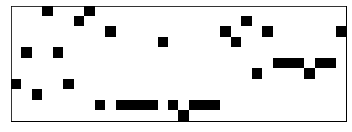

In [23]:
f, ax = plt.subplots()
ax.imshow(smiles_OH, cmap = colors.ListedColormap([(1, 1, 1), 'black']))
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 
plt.show()
f.savefig('smiles_onehot.png',
          dpi=300, facecolor='w', edgecolor='w',
          orientation='portrait',
         transparent=True, bbox_inches=None, pad_inches=0)